## Mount Colab to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
path1 = "/content/drive/My Drive/DAT 490/Datafiles/Crashes.csv"
path2 = "/content/drive/My Drive/DAT 490/Datafiles/People.csv"
path3 = "/content/drive/My Drive/DAT 490/Datafiles/Vehicles.csv"

## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

## Load Data Sets

In [5]:
Crashes = pd.read_csv(path1)
People = pd.read_csv(path2)
Vehicles = pd.read_csv(path3)

# Graphs

## Distribution of Injuries

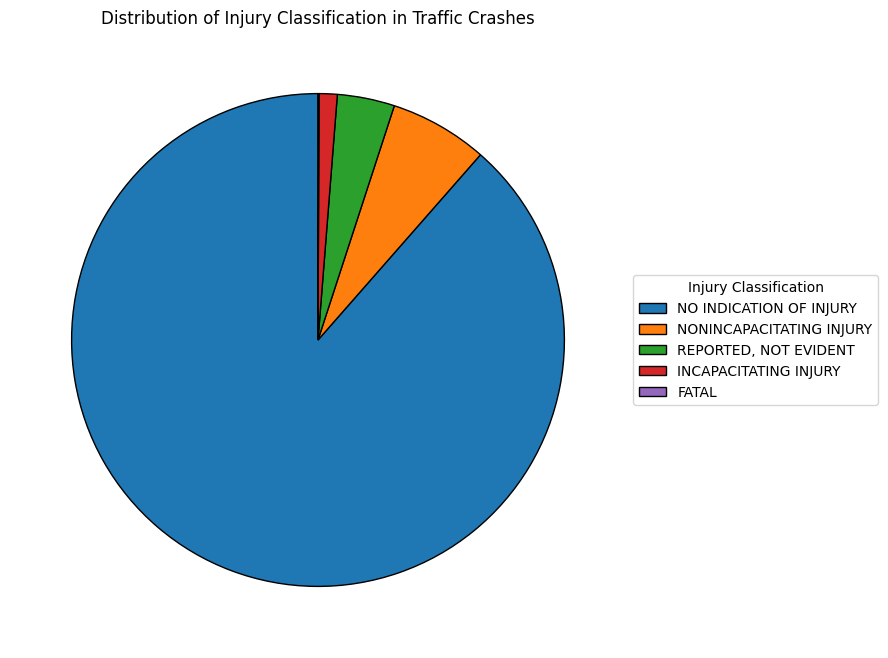

In [6]:
# Counts for different injuries
injury_distribution = People['INJURY_CLASSIFICATION'].value_counts()

# Pie Chart
plt.figure(figsize=(8, 8))
wedges, texts = plt.pie(injury_distribution, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.legend(wedges, injury_distribution.index, title="Injury Classification", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Distribution of Injury Classification in Traffic Crashes')
plt.ylabel('')
plt.show()

## Distribution of Driver Actions

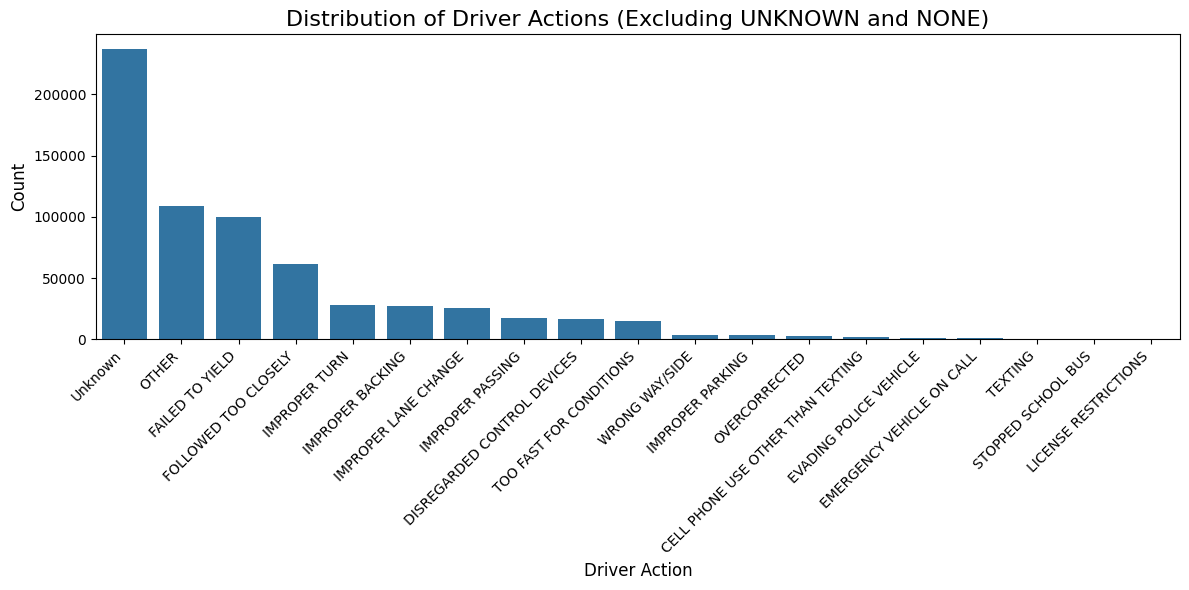

In [7]:
# Filter out 'UNKNOWN' and 'NONE'
filtered_people = People[(People['DRIVER_ACTION'] != 'UNKNOWN') & (People['DRIVER_ACTION'] != 'NONE')]

plt.figure(figsize=(12, 6))

# Counts of driver actions
sns.countplot(data=filtered_people, x='DRIVER_ACTION', order=filtered_people['DRIVER_ACTION'].value_counts().index)


plt.title('Distribution of Driver Actions (Excluding UNKNOWN and NONE)', fontsize=16)
plt.xlabel('Driver Action', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
# datetime format
People['CRASH_DATE'] = pd.to_datetime(People['CRASH_DATE'])

## Driver Actions: Compare pre-COVID and during-COVID

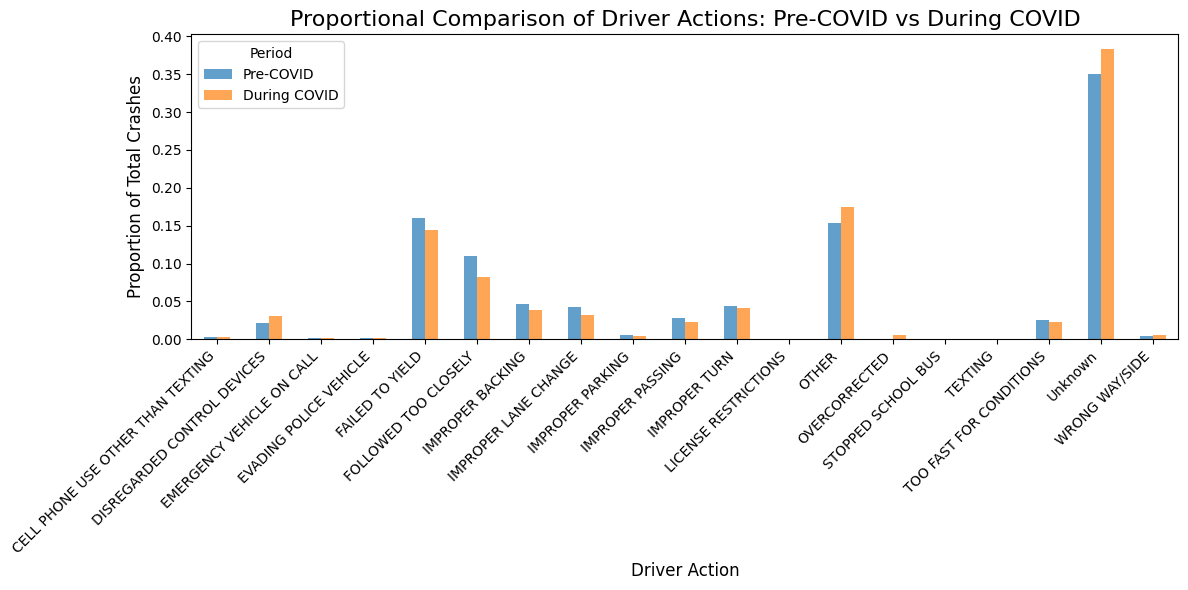

In [11]:
# COVID dates
covid_start_date = pd.to_datetime('2020-03-01')
covid_end_date = pd.to_datetime('2021-12-31')

# pre-COVID and during-COVID dates
pre_covid_data = People[People['CRASH_DATE'] < covid_start_date]
covid_data = People[(People['CRASH_DATE'] >= covid_start_date) & (People['CRASH_DATE'] <= covid_end_date)]

# Filter 'UNKNOWN' and 'NONE' from DRIVER_ACTION
pre_covid_data = pre_covid_data[(pre_covid_data['DRIVER_ACTION'] != 'UNKNOWN') & (pre_covid_data['DRIVER_ACTION'] != 'NONE')]
covid_data = covid_data[(covid_data['DRIVER_ACTION'] != 'UNKNOWN') & (covid_data['DRIVER_ACTION'] != 'NONE')]

# Count of crashes in each period
total_pre_covid_crashes = pre_covid_data.shape[0]
total_covid_crashes = covid_data.shape[0]

# Group counts
pre_covid_driver_action = pre_covid_data['DRIVER_ACTION'].value_counts()
covid_driver_action = covid_data['DRIVER_ACTION'].value_counts()

# Proportion for each period
pre_covid_proportion = pre_covid_driver_action / total_pre_covid_crashes
covid_proportion = covid_driver_action / total_covid_crashes

# Dataframe with proportions
driver_action_proportions = pd.DataFrame({
    'Pre-COVID': pre_covid_proportion,
    'During COVID': covid_proportion
}).fillna(0)

# Plot bar graph
driver_action_proportions.plot(kind='bar', figsize=(12, 6), alpha=0.7)
plt.title('Proportional Comparison of Driver Actions: Pre-COVID vs During COVID', fontsize=16)
plt.xlabel('Driver Action', fontsize=12)
plt.ylabel('Proportion of Total Crashes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Period')
plt.tight_layout()
plt.show()

## Crashes per season: pre-COVID vs during-COVID

<ipython-input-15-3feb19076578>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_covid_data['SEASON'] = pre_covid_data['CRASH_DATE'].apply(find_season)
<ipython-input-15-3feb19076578>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data['SEASON'] = covid_data['CRASH_DATE'].apply(find_season)


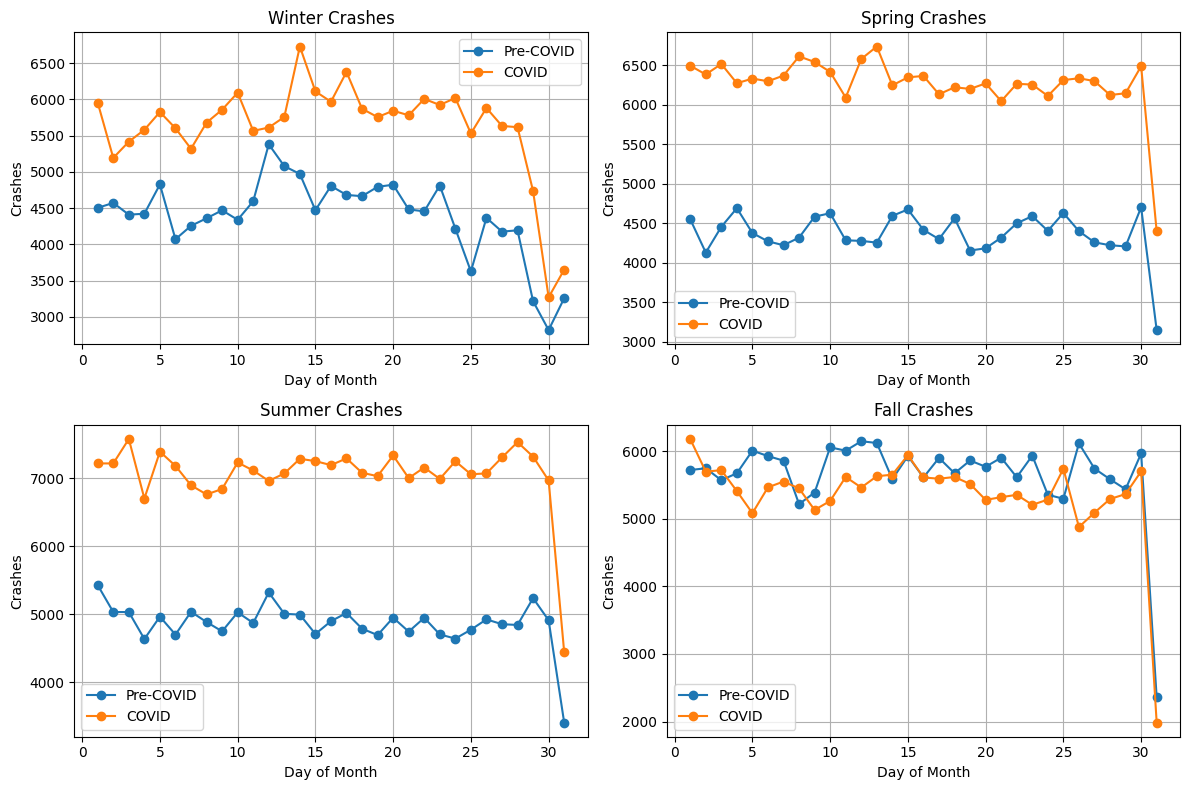

In [15]:
# Function to determine season
def find_season(crash_date):
    if pd.isnull(crash_date):
        return 'Unknown'
    month = crash_date.month
    if month in [12, 1, 2]: # Winter
        return 'Winter'
    elif month in [3, 4, 5]: # Spring
        return 'Spring'
    elif month in [6, 7, 8]: # Summer
        return 'Summer'
    else:
        return 'Fall' # Fall

# Applies find season function and makes new column
pre_covid_data['SEASON'] = pre_covid_data['CRASH_DATE'].apply(find_season)
covid_data['SEASON'] = covid_data['CRASH_DATE'].apply(find_season)

# Define the seasons
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

# 4 plots
plt.figure(figsize=(12, 8))

# Loop through the seasons filter
for i, season in enumerate(seasons):
    plt.subplot(2, 2, i + 1)

    # data for seasons
    pre_covid_season_data = pre_covid_data[pre_covid_data['SEASON'] == season]
    covid_season_data = covid_data[covid_data['SEASON'] == season]

    # Count crashes by days
    pre_covid_counts = pre_covid_season_data['CRASH_DAY'].value_counts().sort_index()
    covid_counts = covid_season_data['CRASH_DAY'].value_counts().sort_index()

    # Plot pre-COVID and COVID data
    plt.plot(pre_covid_counts.index, pre_covid_counts.values, marker='o', label='Pre-COVID')
    plt.plot(covid_counts.index, covid_counts.values, marker='o', label='COVID')
    plt.title(f'{season} Crashes')
    plt.xlabel('Day of Month')
    plt.ylabel('Crashes')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

## Monthly Crash Trends (2018 and later)

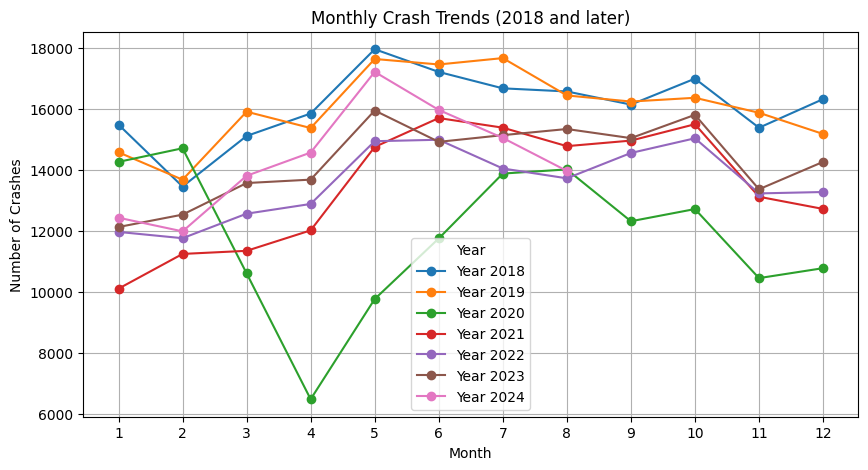

In [13]:
# Covid period
covid_period_data = People[People['CRASH_YEAR'] >= 2018]

# Group data by year and month
monthly_trends = covid_period_data.groupby(['CRASH_YEAR', 'CRASH_MONTH']).size().reset_index(name='Crash_Count')


plt.figure(figsize=(10, 5))

# Loop to go through each year
for year in monthly_trends['CRASH_YEAR'].unique():
    # Boolean mask to find rows for the current year
    is_current_year = monthly_trends['CRASH_YEAR'] == year
    # Filter the data for the current year
    year_data = monthly_trends[is_current_year]
    plt.plot(year_data['CRASH_MONTH'], year_data['Crash_Count'], marker='o', label=f'Year {year}')


plt.title('Monthly Crash Trends (2018 and later)')
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.grid(True)
plt.show()

## BAC Results

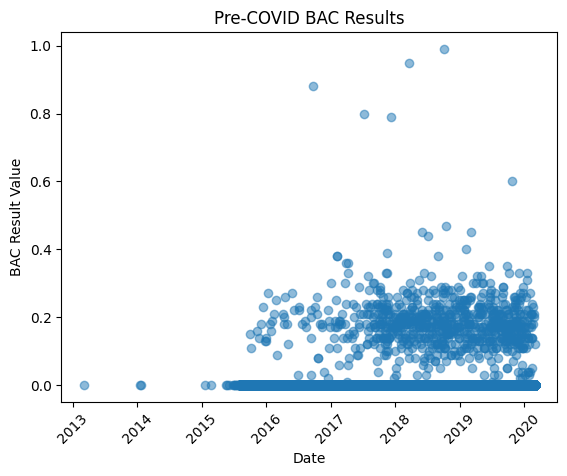

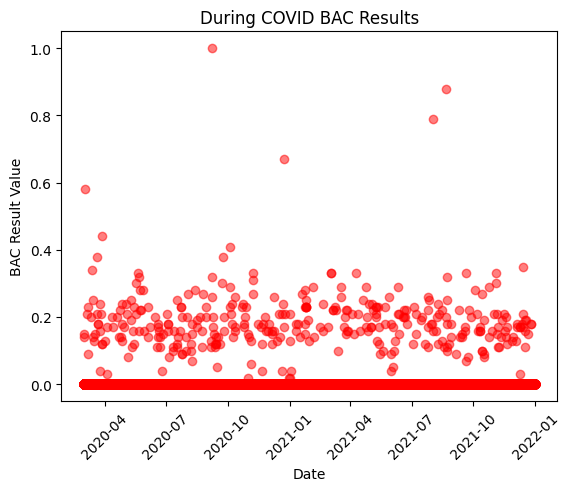

In [12]:
import matplotlib.pyplot as plt

# Pre-COVID scatter plot
plt.scatter(pre_covid_data['CRASH_DATE'], pre_covid_data['BAC_RESULT VALUE'], alpha=0.5)
plt.xlabel('Date')
plt.ylabel('BAC Result Value')
plt.title('Pre-COVID BAC Results')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

# During-COVID scatter plot
plt.scatter(covid_data['CRASH_DATE'], covid_data['BAC_RESULT VALUE'], color='red', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('BAC Result Value')
plt.title('During COVID BAC Results')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()


## Merge and Clean Data sets

In [ ]:
# Merge using 'CRASH_RECORD_ID'
crashes_people_merged = pd.merge(Crashes, People, on=['CRASH_RECORD_ID'], how='left')
merged_data = pd.merge(crashes_people_merged, Vehicles, on=['CRASH_RECORD_ID'],how='left')

In [ ]:
# Drop rows with missing values
full_merged_data = merged_data.dropna()
missing_data_summary_after_drop = full_merged_data.isnull().sum()

## Pre-COVID vs During-COVID

In [1]:
# Sample 10% of the data
data_sample = full_merged_data.sample(frac=0.1, random_state=42)

# Convert 'CRASH_DATE' to datetime
data_sample['CRASH_DATE'] = pd.to_datetime(data_sample['CRASH_DATE'])

# Define COVID start date
covid_start_date = '2020-03-01'

# Split data into pre-COVID and during-COVID
pre_covid_data = data_sample[data_sample['CRASH_DATE'] < covid_start_date]
during_covid_data = data_sample[data_sample['CRASH_DATE'] >= covid_start_date]

# Define features and target
features = ['BAC_RESULT_ENCODED', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE',
            'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
            'ROADWAY_SURFACE_COND', 'AGE', 'SEX']
target = 'INJURY_CLASSIFICATION'

# Split pre-COVID and during-COVID data into features and target
X_pre_covid, y_pre_covid = pre_covid_data[features], pre_covid_data[target]
X_during_covid, y_during_covid = during_covid_data[features], during_covid_data[target]

# Define categorical and numerical features
categorical_features = ['TRAFFIC_CONTROL_DEVICE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
                        'FIRST_CRASH_TYPE', 'ROADWAY_SURFACE_COND', 'SEX']
numeric_features = ['BAC_RESULT_ENCODED', 'POSTED_SPEED_LIMIT', 'AGE']

# Preprocessing pipelines for categorical and numerical features
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median'))])
categorical_pipeline = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Preprocess pre-COVID data using pipelines
X_pre_covid_num = numerical_pipeline.fit_transform(X_pre_covid[numeric_features])
X_pre_covid_cat = categorical_pipeline.fit_transform(X_pre_covid[categorical_features])

# Preprocess during-COVID data using pipelines
X_during_covid_num = numerical_pipeline.fit_transform(X_during_covid[numeric_features])
X_during_covid_cat = categorical_pipeline.fit_transform(X_during_covid[categorical_features])

# Combine preprocessed into dataframe
X_pre_covid_processed = pd.concat([pd.DataFrame(X_pre_covid_num, columns=numeric_features),
                                   pd.DataFrame(X_pre_covid_cat, columns=categorical_pipeline.named_steps['onehot'].get_feature_names_out())], axis=1)

X_during_covid_processed = pd.concat([pd.DataFrame(X_during_covid_num, columns=numeric_features),
                                      pd.DataFrame(X_during_covid_cat, columns=categorical_pipeline.named_steps['onehot'].get_feature_names_out())], axis=1)

# Split pre-COVID and during-COVID data into training and testing sets
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X_pre_covid_processed, y_pre_covid, test_size=0.2, random_state=42)
X_train_during, X_test_during, y_train_during, y_test_during = train_test_split(X_during_covid_processed, y_during_covid, test_size=0.2, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_pre_resampled, y_train_pre_resampled = smote.fit_resample(X_train_pre, y_train_pre)
X_train_during_resampled, y_train_during_resampled = smote.fit_resample(X_train_during, y_train_during)

# Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Train pre-COVID and make predictions
rf.fit(X_train_pre_resampled, y_train_pre_resampled)
y_pred_pre = rf.predict(X_test_pre)

# Train during-COVID and make predictions
rf.fit(X_train_during_resampled, y_train_during_resampled)
y_pred_during = rf.predict(X_test_during)

# Print pre-COVID
print("Pre-COVID:\n", classification_report(y_test_pre, y_pred_pre))
print("Confusion Matrix:\n", confusion_matrix(y_test_pre, y_pred_pre))

# Print during-COVID
print("During-COVID:\n", classification_report(y_test_during, y_pred_during))
print("Confusion Matrix:\n", confusion_matrix(y_test_during, y_pred_during))
